In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [2]:
!unzip -q /kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip 
!unzip -q /kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip

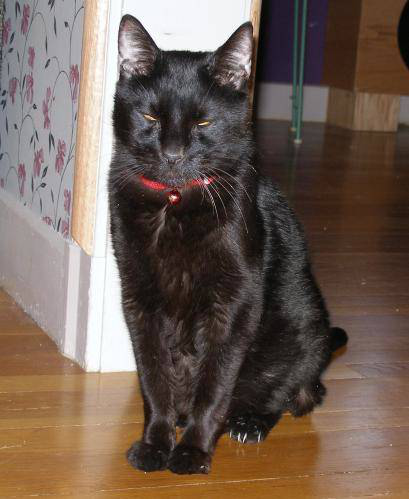

In [3]:
# 1. 이미지를 그림으로, PIL에서 Image.open()

from PIL import Image   #Python Image Library

# os.listdir("train")

Image.open("train/cat.7685.jpg")

In [4]:
# 데이터 전처리

# 1.df만들기, 칼럼2개 - (각각 이미지의 경로, 정답)

train = pd.DataFrame({"path":os.listdir("train")})

train["path"] = "train/"+train["path"]
train["ans"] = train["path"].apply(lambda x : x.split("/")[1].split(".")[0])

train

,path,ans
0,train/cat.78.jpg,cat
1,train/cat.6477.jpg,cat
2,train/cat.3871.jpg,cat
3,train/dog.5695.jpg,dog
4,train/cat.5499.jpg,cat
...,...,...
24995,train/cat.26.jpg,cat
24996,train/cat.1678.jpg,cat
24997,train/cat.2272.jpg,cat
24998,train/dog.9420.jpg,dog


In [5]:
# 평가셋 만들기

from sklearn.model_selection import train_test_split

x_train, x_valid = train_test_split(train, test_size = 0.2, random_state = 42)
# generator에는 정답값(y)이 포함되서 y_train,y_valid는 하지않음

In [6]:
# 이미지 전처리
from keras.preprocessing.image import ImageDataGenerator

idg = ImageDataGenerator()
# 각각의 jpg파일은 픽셀크기가 다를 수 있으므로
# ImageDataGenerator()의 내부함수로 모든 이미지의 크기를 target_size()로 재조정한다. 

# 데이터셋 이름, x경로, y정답값, batch_size, 고정할 사진size

train_generator = idg.flow_from_dataframe(x_train, x_col = "path", y_col = "ans", batch_size = 128, target_size = (200,200))
valid_generator = idg.flow_from_dataframe(x_valid, x_col = "path", y_col = "ans", batch_size = 128, target_size = (200,200))


Using TensorFlow backend.


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [7]:
from keras import Sequential
from keras.layers import *
from keras.applications.inception_v3 import InceptionV3   

model = Sequential()

model.add(Conv2D(32, (3,3), activation = "relu", input_shape = (200,200,3)))                                # Conv2D() : convolution layer로 패턴 학습
# filter옵션 : 얼마나 많은 특징 추출할 것인가, 스스로 가장 잘 나누는 특징을 추출한다
# kernel_szie옵션 : 숫자를 9개씩 sliding, 일반적으로 3x3이 가장 효율적
# activation옵션 : "relu", gradient를 update하면서
# input_shape : 100,100의 사이즈의, 3개의 RGB채널로 나눔

model.add(Conv2D(32, (3,3), activation = "relu"))
model.add(MaxPooling2D())  # 모든 숫자를 중요하게 생각하는 것 방지(사람손,밥그릇..), kernel_size에서 가장 큰 수를 선택한다.

model.add(Conv2D(64, (3,3), activation = "relu"))       # 노드 수 바꿔서 다양한 정보 학습
model.add(Conv2D(64, (3,3), activation = "relu"))
model.add(MaxPooling2D())

model.add(Flatten()) # 차원연결

#-------------------------------------------------------------------------------------
# 배경정보가 중요하지 않다는 것을 이미 학습한 모델 불러오기, pretrain model

# model.add(InceptionV3(weights = "imagenet", include_top = False, pooling = "avg") ) 

#-------------------------------------------------------------------------------------

model.add(Dense(2, activation = "softmax"))

model.compile(metrics = ["acc"], loss = "categorical_crossentropy", optimizer = "adam")

model.fit(train_generator, validation_data = valid_generator, epochs = 2 )
# 이미지 학습에서는 많은 이미지들을 한번에 학습시킬 수 없으므로
# 제너레이터를 만들어 끊어서 학습시킨다(128번씩), 제너레이터에는 정답값도 이미 들어가있다.


Epoch 1/2
157/157 [==============================] - 187s 1s/step - loss: 12.2111 - acc: 0.5694 - val_loss: 0.6006 - val_acc: 0.5956
Epoch 2/2
157/157 [==============================] - 177s 1s/step - loss: 0.6482 - acc: 0.6337 - val_loss: 0.4143 - val_acc: 0.5912


In [8]:
# os.listdir("test")

test = pd.DataFrame({"path":os.listdir("test")})

test["path"] = "test/"+test["path"]
test

idg2 = ImageDataGenerator()

test_generator = idg2.flow_from_dataframe(test, x_col = "path", y_col = None, batch_size = 128, target_size = (200,200), class_mode = None, shuffle = False)
# test제너레이터에는 옵션 2개 추가
# class_mode = None , shuffle = False : 섞어서 제출하는 것 방지

result = model.predict(test_generator)

Found 12500 validated image filenames.


In [9]:
sub = pd.read_csv("/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv")
sub.head()

,id,label
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5


In [10]:
sub["id"] = test_generator.filenames

sub["id"] = sub["id"].apply(lambda x : x.split("/")[1].split(".")[0])

sub["label"] = result[:,1]

sub.head()

,id,label
0,10522,0.566571
1,4124,0.672699
2,12107,0.551873
3,10809,0.455948
4,6378,0.732223


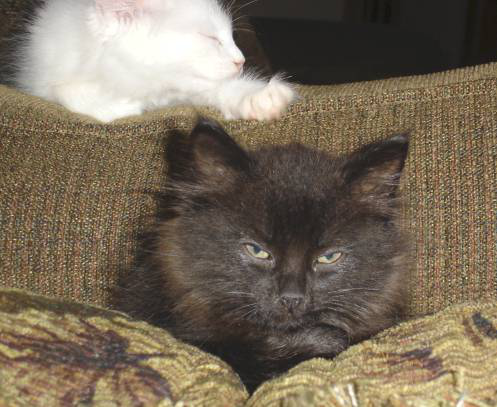

In [29]:
# sub.head(50)

Image.open("test/206.jpg")
# 확률이 거의 절반인 사진 중 하나 
# 이유 : 두마리의 얼굴이 포함돼서

In [12]:
sub.to_csv("sub.csv", index=False)